In [1]:
# 共通事前處理
# 隱藏不必要的警告
import warnings
warnings.filterwarnings('ignore')

# 匯入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 將字型新增到 matplotlib
fm.fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')

# 用來顯示資料框的函式
from IPython.display import display

# 調整顯示選項
# NumPy 的浮點數表示精度
np.set_printoptions(suppress=True, precision=4)
# pandas 中的浮點數表示精度
pd.options.display.float_format = '{:.4f}'.format
# 顯示資料框中的所有項目
pd.set_option("display.max_columns",None)
# 指定圖形的預設字體大小
plt.rcParams["font.size"] = 14
# 指定圖形的預設字型
plt.rcParams['font.family'] = 'Taipei Sans TC Beta'
# 隨機種子
random_seed = 2277

In [ ]:
#載入資料、確認資料
df = pd.read_csv('stockData.csv', parse_dates=[1])
df.to_html('dataset_TWII.html')
column = ['指數代碼', '日期', '開盤價', '最高價', '最低價', '收盤價', '調整後收盤價', '交易量']
df.columns = column


display(df.head())
display(df.tail())

,指數代碼,日期,開盤價,最高價,最低價,收盤價,調整後收盤價,交易量
0,NYA,1965-12-31,528.6900,528.6900,528.6900,528.6900,528.6900,0.0000
1,NYA,1966-01-03,527.2100,527.2100,527.2100,527.2100,527.2100,0.0000
2,NYA,1966-01-04,527.8400,527.8400,527.8400,527.8400,527.8400,0.0000
3,NYA,1966-01-05,531.1200,531.1200,531.1200,531.1200,531.1200,0.0000
4,NYA,1966-01-06,532.0700,532.0700,532.0700,532.0700,532.0700,0.0000


,指數代碼,日期,開盤價,最高價,最低價,收盤價,調整後收盤價,交易量
112452,N100,2021-05-27,1241.1200,1251.9100,1241.1200,1247.0699,1247.0699,379696400.0000
112453,N100,2021-05-28,1249.4700,1259.2100,1249.0300,1256.6000,1256.6000,160773400.0000
112454,N100,2021-05-31,1256.0800,1258.8800,1248.1400,1248.9301,1248.9301,91173700.0000
112455,N100,2021-06-01,1254.6100,1265.6600,1254.6100,1258.5800,1258.5800,155179900.0000
112456,N100,2021-06-02,1258.4900,1263.7100,1258.2400,1263.6200,1263.6200,148465000.0000


In [48]:
# 確認遺失值、欲處理資料
missing_rows = df[df.isnull().any(axis=1)]
# 查看有遺失值的列(最後5列)
display(missing_rows.tail())
# 向前填充遺失值，同df.fillnu(method='ffill')
df_filled = df.ffill()
#df_filled.isnull().sum()

,指數代碼,日期,開盤價,最高價,最低價,收盤價,調整後收盤價,交易量
108316,N100,2005-03-28,NaN,NaN,NaN,NaN,NaN,NaN
108511,N100,2005-12-26,NaN,NaN,NaN,NaN,NaN,NaN
110051,N100,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN
110643,N100,2014-05-01,NaN,NaN,NaN,NaN,NaN,NaN
112090,N100,2019-12-25,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_tw = df_filled[df_filled['指數代碼']=='TWII']
print(df_tw.isnull().sum())

指數代碼      0
日期        0
開盤價       0
最高價       0
最低價       0
收盤價       0
調整後收盤價    0
交易量       0
dtype: int64


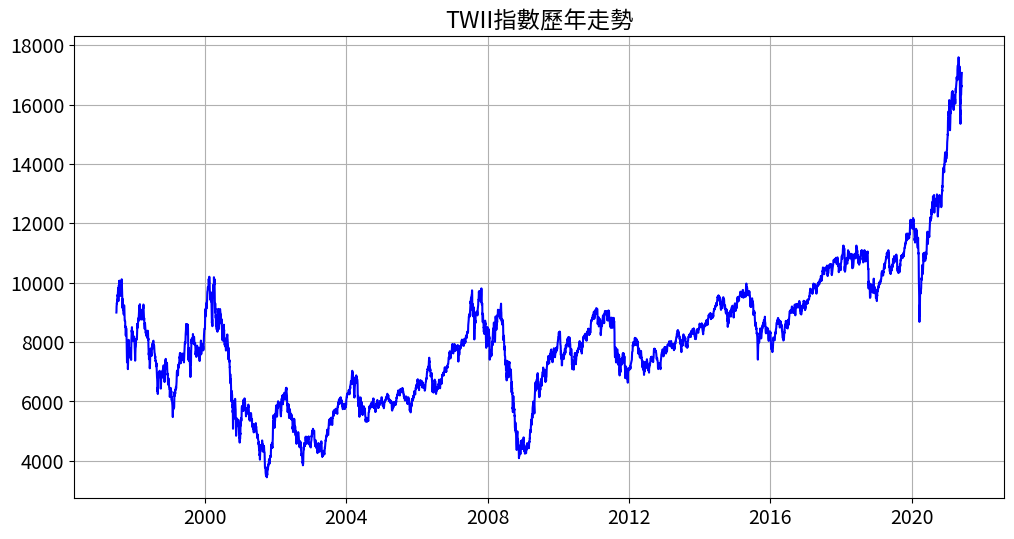

In [50]:
#繪製時間序列資料圖，因為要預測時間的[調整後收盤價]
plt.figure(figsize=(12,6))
plt.plot(df_tw['日期'], df_tw['調整後收盤價'], color='b')
plt.title('TWII指數歷年走勢')

plt.grid() #顯示網格
plt.show()

In [51]:
# 建立核心滯後特徵
# 1. 計算當天的日對數報酬率
# current_log_return 的 t 值 = (Adj Close_t / Adj Close_{t-1})
df_tw['current_log_return'] = np.log(df_tw['調整後收盤價'] / df_tw['調整後收盤價'].shift(1))

# 2. **關鍵步驟：將當日報酬率滯後一天**
# lagged_return 的 t 值，儲存的是 t-1 日的報酬率
df_tw['lagged_return'] = df_tw['current_log_return'].shift(1)
print("lagged_return 欄位已成功創建。")

lagged_return 欄位已成功創建。


In [52]:
# 擴展 XGBoost 所需的特徵
# 1. 創建更多滯後價格特徵 (Lagged Price Features)
# 使用 t-1, t-5, t-10 日的價格來預測今天的價格
for i in [1, 5, 10]:
    df_tw[f'lagged_price_{i}'] = df_tw['調整後收盤價'].shift(i) #使用f字串

# 2. 創建移動平均特徵 (Rolling Mean)
# 捕捉短期和中期的價格趨勢
for s in [5, 20]:
    # 這裡的 shift(1) 確保計算的是 t-1 日為止的平均值，避免未來資訊洩漏
    df_tw[f'rolling_mean_{s}'] = df_tw['調整後收盤價'].shift(1).rolling(window=s).mean()

# 3. 創建日期特徵 (從 ds 欄位提取)
df_tw['年'] = df_tw['日期'].dt.year
df_tw['月'] = df_tw['日期'].dt.month
df_tw['週'] = df_tw['日期'].dt.dayofweek # 0=週一, 6=週日
df_tw['日'] = df_tw['日期'].dt.dayofyear

df_tw2 = df_tw.dropna().copy()
print(f"XGBoost 特徵工程完成。總共 {len(df_tw2)} 筆資料可用。")

XGBoost 特徵工程完成。總共 5990 筆資料可用。


In [53]:
# 調整欄位名稱
df_tw2.columns = ['指數代碼', '日期', '開盤價', '最高價', '最低價', '收盤價', '調整後收盤價', '交易量',
                    '當前報酬率', '滯後報酬率', '滯後價格(t-1日)', '滯後價格(t-5日)', '滯後價格(t-10日)',
                    '移動平均值(5日)', '移動平均值(10日)', '年', '月', '週', '日']
display(df_tw2.head())

,指數代碼,日期,開盤價,最高價,最低價,收盤價,調整後收盤價,交易量,當前報酬率,滯後報酬率,滯後價格(t-1日),滯後價格(t-5日),滯後價格(t-10日),移動平均值(5日),移動平均值(10日),年,月,週,日
84073,TWII,1997-07-30,9953.9404,10000.6104,9898.2998,9942.7900,9942.7520,0.0000,0.0051,-0.0031,9892.3027,9381.0254,9544.5244,9727.5193,9499.8302,1997,7,2,211
84074,TWII,1997-07-31,10111.8301,10113.5703,10050.9297,10066.3496,10066.3115,0.0000,0.0124,0.0051,9942.7520,9632.3838,9571.7637,9839.8646,9547.1334,1997,7,3,212
84075,TWII,1997-08-01,9953.3096,10102.7695,9942.3398,10001.5596,10001.5215,0.0000,-0.0065,0.0124,10066.3115,9808.8730,9677.3643,9926.6502,9599.0692,1997,8,4,213
84076,TWII,1997-08-04,10167.3096,10167.3096,10059.0898,10065.7598,10065.7217,0.0000,0.0064,-0.0065,10001.5215,9923.0117,9833.7324,9965.1799,9639.5185,1997,8,0,216
84077,TWII,1997-08-05,10077.0801,10077.0801,9914.0996,9919.6797,9919.6416,0.0000,-0.0146,0.0064,10065.7217,9892.3027,9550.3652,9993.7219,9676.6643,1997,8,1,217


In [54]:
# 切分數據並定義 X, Y
# 日期分割
train_end_date = pd.to_datetime('2010-12-31')
validation_end_date = pd.to_datetime('2016-12-31')

# 切分數據
# 把2005-12-31(含)前的資料指派給train_df
train_df = df_tw2[df_tw2['日期'] <= train_end_date]
# 把2015-12-31(含)前的資料指派給validation_df
validation_df = df_tw2[(df_tw2['日期'] <= validation_end_date) & (df_tw2['日期'] > train_end_date)] #注意pd中的and要用'&'代替，且是優先運算因子
# 把2015-12-31(含)後的資料指派給test_df
test_df = df_tw2[df_tw2['日期'] > validation_end_date]

# 定義特徵欄位
# 排除 ds (日期), Adj Close (目標), current_log_return (未來資訊), 指數代碼
exclude_cols = ['指數代碼', '日期', '調整後收盤價', '開盤價', '收盤價', '最高價', '最低價', '指數代碼', '當前報酬率','交易量']
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# 定義 X 和 Y
x_train = train_df[feature_cols]
y_train = train_df['調整後收盤價']

x_val = validation_df[feature_cols]
y_val = validation_df['調整後收盤價']

x_test = test_df[feature_cols]
y_test = test_df['調整後收盤價']

print(f"特徵數量: {len(feature_cols)} 個")
print(f"x_train 筆數: {len(x_train)}")

特徵數量: 10 個
x_train 筆數: 3440


In [55]:
import xgboost as xgb
# 1. 將數據轉換為 XGBoost 專用的 DMatrix 格式
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)

# 2. 定義模型參數
params = {
    'objective': 'reg:squarederror',
    'eta': 0.05, # 相當於 learning_rate
    'max_depth': 5,
    'seed': 42,
    'nthread': -1 # 相當於 n_jobs
}

# 3. 訓練模型 (使用 xgb.train 函式)
# num_boost_round 相當於 n_estimators
# evals 相當於 eval_set
# early_stopping_rounds 直接作為參數傳遞

xgb_model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    num_boost_round=1000, 
    evals=[(dval, 'validation')], # 驗證集設定
    early_stopping_rounds=50, # <--- 這是原生 API 支援的參數！
    verbose_eval=False # 關閉訓練過程的冗長輸出
)

print(f"XGBoost 原生 API 模型訓練完成，最佳迭代次數: {xgb_model.best_iteration}")

XGBoost 原生 API 模型訓練完成，最佳迭代次數: 152


In [56]:
# 4. 進行預測
# 原生 API 的預測使用 model.predict(DMatrix)
y_pred_val = xgb_model.predict(dval)

In [57]:
# 5. 評估驗證集結果 (不變)
from sklearn.metrics import mean_squared_error, r2_score
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

print(f"\n--- TWII (XGBoost 原生 API) 驗證集結果 ---")
print(f"驗證集 R2_score: {r2_val:.4f}")
print(f"驗證集 RMSE: {rmse_val:.4f}")


--- TWII (XGBoost 原生 API) 驗證集結果 ---
驗證集 R2_score: 0.9843
驗證集 RMSE: 91.4032


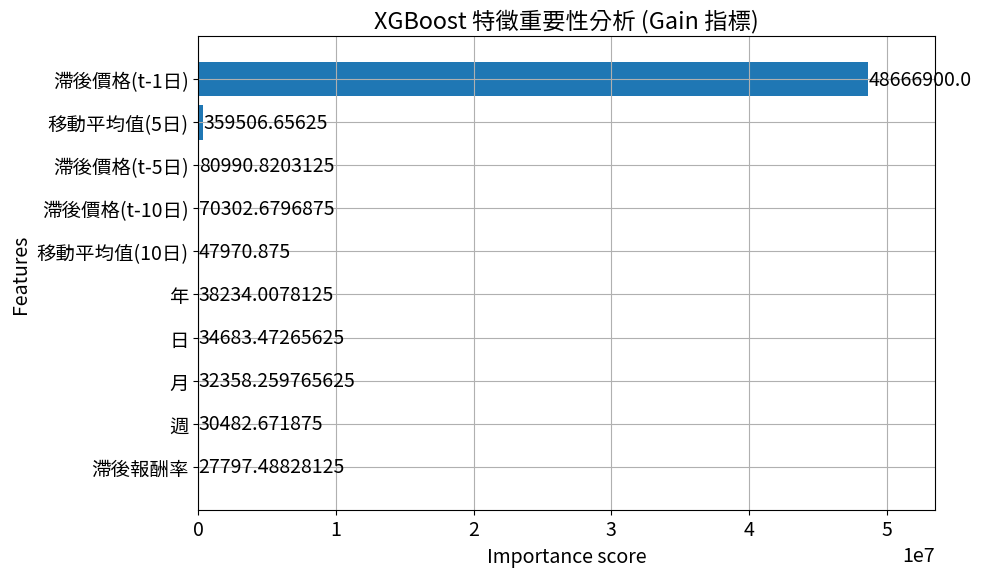

In [58]:
# 對指數走勢價格進行重要性分析

fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(
    xgb_model, 
    ax=ax, 
    height=0.8,
    importance_type='gain', 
    show_values=True,
    title='XGBoost 特徵重要性分析 (Gain 指標)'
    )

plt.tight_layout() # 自動調整佈局，防止標籤被裁切
plt.show()

In [60]:
# 準備測試集數據
# 轉換為 DMatrix 格式
dtest = xgb.DMatrix(x_test, label=y_test)
# 進行預測
y_pred_test = xgb_model.predict(dtest)
# 評估測試集結果
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
print(f"\n--- TWII (XGBoost 修正後) 測試集最終結果 ---")
print(f"測試集 R2_score: {r2_test:.4f}")
print(f"測試集 RMSE: {rmse_test:.4f}")


--- TWII (XGBoost 修正後) 測試集最終結果 ---
測試集 R2_score: -0.6686
測試集 RMSE: 2350.5567
